In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
from tensorflow.keras.datasets import mnist 
from tensorflow.keras.utils import to_categorical

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 784).astype(np.float32) / 255.0
X_test = X_test.reshape(-1, 784).astype(np.float32) / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [4]:
#Hyperparameters
input_size = 784
hidden_layer_1_size = 512
hidden_layer_2_size = 128
output_size = 10
learning_rate = 0.001
epochs = 10
batch_size = 64
dropout_rate = 0.5
momentum = 0.9  # for moving averages in batch norm

In [5]:
# Weights & Biases Initialization
W1 = tf.Variable(tf.random.normal([input_size, hidden_layer_1_size], stddev=0.1), name="W1")
b1 = tf.Variable(tf.zeros([hidden_layer_1_size]), name="b1")

W2 = tf.Variable(tf.random.normal([hidden_layer_1_size, hidden_layer_2_size], stddev=0.1), name="W2")
b2 = tf.Variable(tf.zeros([hidden_layer_2_size]), name="b2")

W3 = tf.Variable(tf.random.normal([hidden_layer_2_size, output_size], stddev=0.1), name="W3")
b3 = tf.Variable(tf.zeros([output_size]), name="b3")

In [6]:
#Batch Norm gamma and beta
gamma1 = tf.Variable(tf.ones([hidden_layer_1_size]), name='gamma1')
beta1 = tf.Variable(tf.zeros([hidden_layer_1_size]), name='beta1')

gamma2 = tf.Variable(tf.ones([hidden_layer_2_size]), name='gamma2')
beta2 = tf.Variable(tf.zeros([hidden_layer_2_size]), name='beta2')

In [7]:
# Batch Norm moving averages (non-trainable)
mean_running1 = tf.Variable(tf.zeros([hidden_layer_1_size]), trainable=False)
var_running1 = tf.Variable(tf.ones([hidden_layer_1_size]), trainable=False)

mean_running2 = tf.Variable(tf.zeros([hidden_layer_2_size]), trainable=False)
var_running2 = tf.Variable(tf.ones([hidden_layer_2_size]), trainable=False)

In [8]:
def batch_norm(x, gamma, beta, mean_running, var_running, training=True):
    if training:
        mean, var = tf.nn.moments(x, axes=[0])
        # Update running averages
        mean_running.assign(momentum * mean_running + (1 - momentum) * mean)
        var_running.assign(momentum * var_running + (1 - momentum) * var)
        x_norm = (x - mean) / tf.sqrt(var + 1e-8)
    else:
        x_norm = (x - mean_running) / tf.sqrt(var_running + 1e-8)
    return gamma * x_norm + beta

In [9]:
#Forward Pass with ReLU and Batch Norm
def forward_pass(x, training=True):
    z1 = tf.matmul(x, W1) + b1
    bn1 = batch_norm(z1, gamma1, beta1, mean_running1, var_running1, training)
    a1 = tf.nn.relu(bn1)
    if training:
        a1 = tf.nn.dropout(a1, rate=dropout_rate)

    z2 = tf.matmul(a1, W2) + b2
    bn2 = batch_norm(z2, gamma2, beta2, mean_running2, var_running2, training)
    a2 = tf.nn.relu(bn2)
    if training:
        a2 = tf.nn.dropout(a2, rate=dropout_rate)

    z3 = tf.matmul(a2, W3) + b3
    output = tf.nn.softmax(z3)
    return output

In [10]:
def compute_loss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, 1e-10, 1.0)
    return -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))


In [11]:
def compute_accuracy(y_true, y_pred):
    correct_preds = tf.equal(tf.argmax(y_true, axis=1), tf.argmax(y_pred, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))
    return accuracy

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [13]:
# Training Loop
train_loss_history = []
train_acc_history = []

test_loss_history = []
test_acc_history = []

for epoch in range(epochs):
    # Shuffle training data each epoch
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]

    total_loss = 0
    total_accuracy = 0
    num_batches = int(X_train.shape[0] / batch_size)

    for i in range(num_batches):
        start = i * batch_size
        end = start + batch_size
        x_batch, y_batch = X_train[start:end], y_train[start:end]

        with tf.GradientTape() as tape:
            logits = forward_pass(x_batch, training=True)
            loss = compute_loss(y_batch, logits)

        grads = tape.gradient(loss, [W1, b1, gamma1, beta1,
                                     W2, b2, gamma2, beta2,
                                     W3, b3])
        optimizer.apply_gradients(zip(grads, 
                                     [W1, b1, gamma1, beta1,
                                      W2, b2, gamma2, beta2,
                                      W3, b3]))

        total_loss += loss.numpy()
        batch_acc = compute_accuracy(y_batch, logits).numpy()
        total_accuracy += batch_acc

    avg_loss = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches

    train_loss_history.append(avg_loss)
    train_acc_history.append(avg_accuracy)

    # Evaluate on test set after each epoch
    logits_test = forward_pass(X_test, training=False)
    test_loss = compute_loss(y_test, logits_test).numpy()
    test_acc = compute_accuracy(y_test, logits_test).numpy()

    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Training Accuracy: {avg_accuracy:.4f}, Test Accuracy: {test_acc:.4f}")


Epoch 1, Loss: 0.5097, Training Accuracy: 0.8451, Test Accuracy: 0.9504
Epoch 2, Loss: 0.2494, Training Accuracy: 0.9248, Test Accuracy: 0.9655
Epoch 3, Loss: 0.1976, Training Accuracy: 0.9403, Test Accuracy: 0.9700
Epoch 4, Loss: 0.1630, Training Accuracy: 0.9499, Test Accuracy: 0.9746
Epoch 5, Loss: 0.1423, Training Accuracy: 0.9569, Test Accuracy: 0.9761
Epoch 6, Loss: 0.1300, Training Accuracy: 0.9611, Test Accuracy: 0.9785
Epoch 7, Loss: 0.1187, Training Accuracy: 0.9637, Test Accuracy: 0.9803
Epoch 8, Loss: 0.1106, Training Accuracy: 0.9664, Test Accuracy: 0.9800
Epoch 9, Loss: 0.1015, Training Accuracy: 0.9685, Test Accuracy: 0.9808
Epoch 10, Loss: 0.0940, Training Accuracy: 0.9712, Test Accuracy: 0.9820


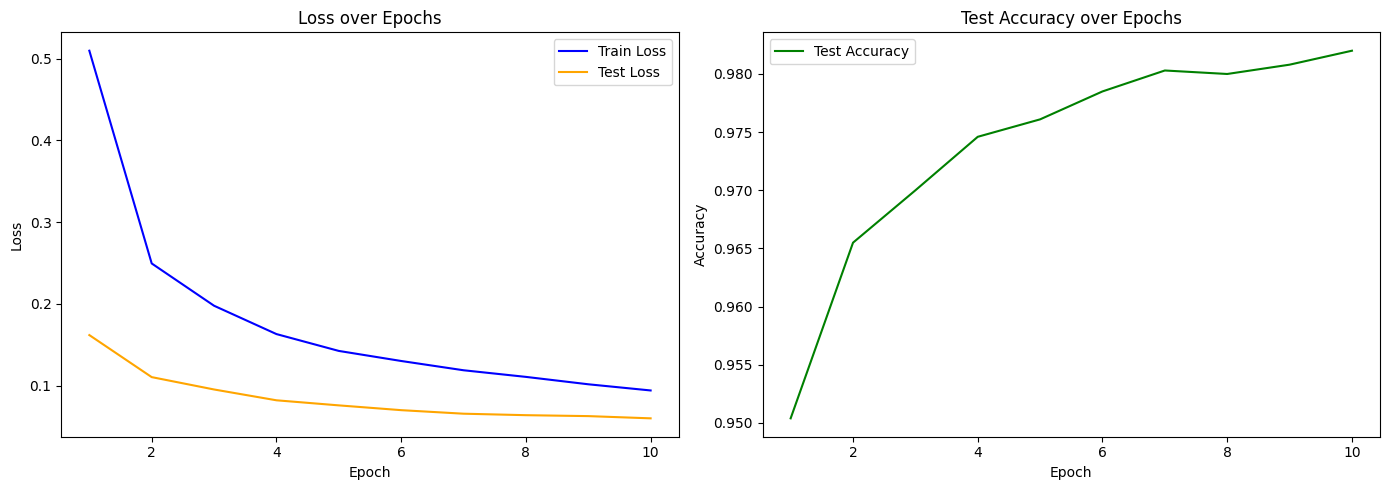

In [14]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, label='Train Loss', color='blue')
plt.plot(epochs_range, test_loss_history, label='Test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_acc_history, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

